In [784]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("max_rows", 2000)

In [785]:
# Get all stats
paths = glob("data/*")
dataPaths = {}
for path in paths:
    start = path.replace(".", "", 2).find(".") + 3
    end = path.find("2020") - 1
    dataPaths.update({path[start:end]: path})

In [825]:
# Read but skip first row of each csv
dataframes = {}
for name in dataPaths:
    dataframes.update({name:pd.read_csv(dataPaths[name], skiprows=[0], index_col=False)})

    
# Helper Functions
def convertToDate(series):
    return pd.to_datetime(series, format='%Y-%m-%d %H:%M:%S')

def getDayOfWeek(dates):
    """Returns dayofweek of each tuple in series"""
    return dates.map(lambda date: date.dayofweek)

def getDays(df):
    """Returns a list of dataframes, each representing a day of the week"""
    return [df[df["dayofweek"] == i] for i in range(7)] 


# Init functions
def initDaysum(remvOutlier=True, start=None, end=None):
    daysum = dataframes["activity.day_summary"]
    for datecol in ["update_time", "create_time"]:
        daysum[datecol] = convertToDate(daysum[datecol])
    
    daysum.index =  daysum["create_time"]
    daysum = daysum.sort_index()
    
    if remvOutlier:
        # Slice off weird outlier
        before = (daysum.index < "2019-01-28 21:12:40.484")
        after = (daysum.index > "2019-01-28 21:12:41.745")
        daysum = daysum.loc[before | after]
    
    if start and end:
        daysum = daysum.loc[start:end]
        
    return daysum

def initSleep(start=None, end=None):
    columns = ["com.samsung.health.sleep.start_time", 
               "com.samsung.health.sleep.end_time", 
               "com.samsung.health.sleep.create_time",
               "com.samsung.health.sleep.update_time",
               "com.samsung.health.sleep.time_offset"]
    sleep = dataframes["sleep"][columns]
    sleep.columns = ["start_time", "end_time", "create_time", "update_time", "time_offset"]
    
    sleep.index = sleep["start_time"]
    sleep.sort_index(inplace=True)
    
    for datecol in ["start_time", "end_time", "create_time", "update_time"]:
        sleep[datecol] = convertToDate(sleep[datecol])
    
    if start and end:
        sleep = sleep.loc[start:end]
        
    return sleep

In [826]:
[print(df) for df in dataframes.keys()]
None

caffeine_intake
device_profile
food_info
food_intake
height
nutrition
user_profile
water_intake
weight
activity.day_summary
activity.goal
activity_level
best_records
caloric_balance_goal
calories_burned.details
exercise
exercise.weather
food_favorite
food_frequent
food_goal
goal
goal_history
insight.hourly_accumulated_active_time
insight.milestones
preferences
report
rewards
sleep
social.leaderboard
social.public_challenge
social.public_challenge.extra
social.public_challenge.history
social.service_status
step_daily_trend
tracker.pedometer_day_summary
tracker.pedometer_recommendation
tracker.pedometer_step_count


1st semester 2nd yr ["2019-09-01":"2019-12-10"]

In [829]:
daysum = initDaysum(start="2020-09-01", end="2090-09-01")

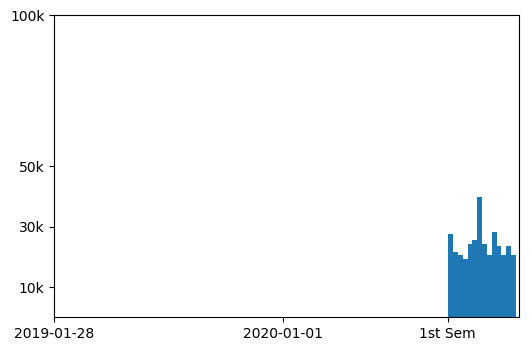

In [904]:
fig, ax = plt.subplots()
fig.dpi = 100

months = len(daysum["create_time"]) // 7
ax.hist(daysum["create_time"], weights=daysum["step_count"], bins=months)

ax.xaxis.set_ticks(["2019-01-28", "2020-01-01", "2020-09-01"])
ax.xaxis.set_ticklabels(["2019-01-28", "2020-01-01", "1st Sem"])

ax.yaxis.set_ticks([10**4, 3 * 10**4, 5 * 10**4, 10**5])
ax.yaxis.set_ticklabels(["10k", "30k", "50k", "100k"])
None

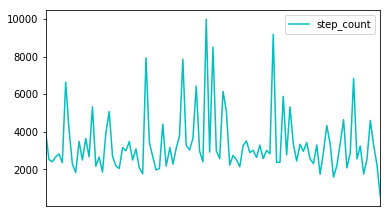

In [905]:
ax = daysum["step_count"].plot(style="c-")
ax.set_xticks([])
ax.set_xlabel("")
ax.legend()
None

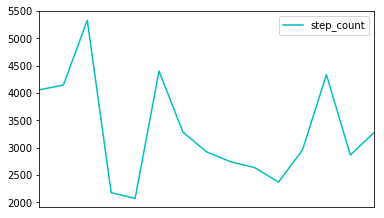

In [906]:
filt = [i % 7 == 0 for i in range(len(s))]
ax = daysum["step_count"][filt].plot(style="c-")
ax.set_xticks([])
ax.set_xlabel("")
ax.legend()
None

In [902]:
daysum["dayofweek"] = getDayOfWeek(daysum["create_time"])
days = getDays(daysum)

if "toDay" not in dir():
    dayLabels = "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
    toDay = {i:day for i, day in zip(range(7), dayLabels)}
    toDay.update({v:k for k, v in toDay.items()})
    
daysum.groupby("dayofweek")["step_count"].agg(["mean", "median", "std"]).round(2)

,mean,median,std
dayofweek,,,
0,3966.64,2969.5,2456.00
1,3305.00,2959.0,945.92
2,3465.67,2522.0,1999.85
3,2803.64,2560.5,1659.55
4,3211.47,3005.0,1206.68
5,3267.00,3208.0,985.73
6,3587.14,2718.0,1961.99


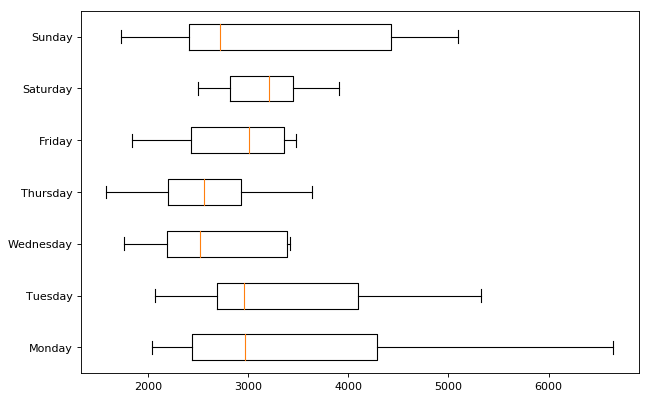

In [903]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=80)

ax.boxplot([d["step_count"] for d in days], labels=dayLabels, vert=False, showfliers=False)
None